# Creating a Bell state with pulses on Rigetti's Aspen M-3

Let's create a Bell state program, the `Hello world!` example in quantum computing, with pulses on a Rigetti's device. 

The canonical circuit to generate a Bell pair is constitued of an Hadamard gate on a first qubit followed by a CNOT gate between this qubit and a second qubit. In this notebook, we will realize that creating entangled states requires specific mechanisms that are tightly connected to the hardware type and device architecture. Specifically here, we will focus on the native gate set of the Rigetti's device and choose to use specific waveforms and frames that enable native CZ gates.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Let's first import few packages.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from braket.aws import AwsDevice
from braket.pulse import PulseSequence, ArbitraryWaveform

from braket.circuits import Circuit, QubitSet
import braket.circuits.circuit as circuit
from braket.circuits.gates import CZ

from utils.draw_pulse_sequence import draw_multiple_frames
from utils.extract_phases import extract_phases

We will use two qubits, #10 amd #113, that are physically connected to each other. We also instantiate a Rigetti device to extract frames and submit circuits.

In [3]:
a=10
b=113

device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

## Bell pair with the H and Ctrl-Z gates

First we show how to transform our common Bell state circuit into one that contains a CZ gate instead of a CNOT gate.

As, CNOT and CZ only differ by a basis transform, we will add Hadamard gates before and after the CZ gate. 

In [4]:
bell_pair_with_gates = Circuit().h(a).h(b).cz(a, b).h(b)
print(bell_pair_with_gates)

T    : |0|1|2|
              
q10  : -H-C---
          |   
q113 : -H-Z-H-

T    : |0|1|2|


The circuit is then executed on the Aspen-M-3 device and we plot the measurement histogram which hints that we created $$\frac{|00\rangle+|11\rangle}{\sqrt{2}}$$

We use `disable_qubit_rewiring = True` to be sure that the Bell pair will be created on the specified qubit and not on remapped qubits so we have a fair comparison with the rest of the notebook.

Text(0, 0.5, 'Population')

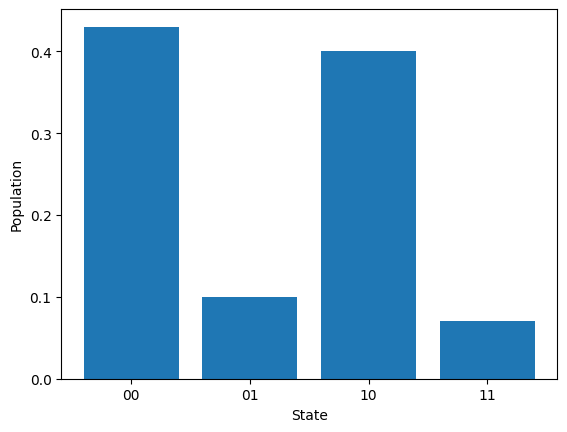

In [5]:
nb_shots = 100
task = device.run(bell_pair_with_gates, shots = nb_shots, disable_qubit_rewiring=True)
counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

## Bell pair with the pulse implementation of CZ

Since Hadamard gates are not native gates on Aspen, we cannot add them to circuits containing pulse sequences. We need to first decompose them into a sequence of native gates. We will use the RX and RZ gates here.

We will annotate this decomposition with `circuit.subroutine` to register this as a custom gate in the circuit allowing easy reuse.

In [6]:
@circuit.subroutine(register=True)
def rigetti_native_h(q0):
    return (
        Circuit()
        .rz(q0, np.pi)
        .rx(q0, np.pi/2)
        .rz(q0, np.pi/2)
        .rx(q0, -np.pi/2)
    )
    
print(Circuit().rigetti_native_h(a))

T   : |   0    |   1    |   2    |    3    |
                                            
q10 : -Rz(3.14)-Rx(1.57)-Rz(1.57)-Rx(-1.57)-

T   : |   0    |   1    |   2    |    3    |


For the CZ gate, we will use an arbitrary waveform with parameters (amplitude, rise/fall time, duration) that have been predetermined beforehand. This waveform will be applied on the `q10_q113_cz_frame` frame. We will retrieve the arbitrary form from the device calibrations.

In [7]:
cz_a_b = device.native_gate_calibration.get_pulse_sequence((CZ(), QubitSet([a, b])))
a_b_cz_wfm = cz_a_b._waveforms[f"q{a}_q{b}_cz_CZ"]

To draw this waveform as it will be played on the device, we need to know the frame and the corresponding time separation between each sample. This information is stored in the device capabilities. 

First we retrieve the frame that we will use to create a CZ gate between qubit 10 and 113. The minimum time increment can then be extracted through the corresponding port.

The pulse length will be the product of the number of samples and the minimum time increment. 

In [8]:
a_b_cz_frame = device.frames[f'q{a}_q{b}_cz_frame']
dt=a_b_cz_frame.port.dt

a_b_cz_wfm_duration = len(a_b_cz_wfm.amplitudes)*dt
print('CZ pulse duration:', round(a_b_cz_wfm_duration * 1e9,0), 'ns')

CZ pulse duration: 168.0 ns


With all these data, we call also plot the waveform and see that it is rounded square pulse. 

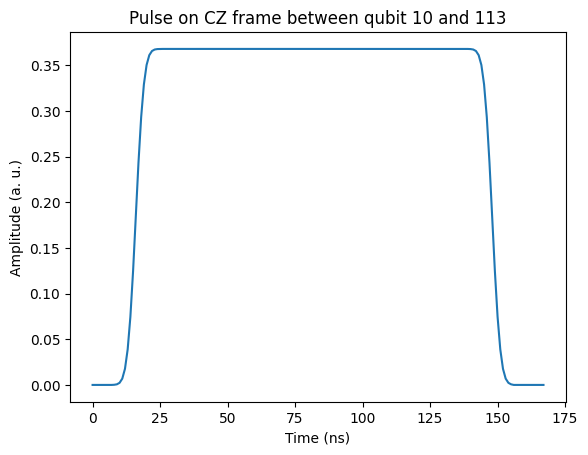

In [9]:
plt.plot(np.arange(0, len(a_b_cz_wfm.amplitudes))*dt*1e9, [amp.real for amp in a_b_cz_wfm.amplitudes])
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (a. u.)')
plt.title(f'Pulse on CZ frame between qubit {a} and {b}');

Playing the CZ waveform on a frame that is related to a fast-flux port enable a CZ interaction that causes the systems to oscillate between $|11\rangle$ and $|20\rangle$.

In [10]:
a_rf_frame = device.frames[f'q{a}_rf_frame']
b_rf_frame = device.frames[f'q{b}_rf_frame']
frames = [a_rf_frame, b_rf_frame, a_b_cz_frame]

cz_pulse_sequence = (
    PulseSequence()
    .barrier(frames)
    .play(a_b_cz_frame, a_b_cz_wfm)
)

One side-effect of this pulse that that the mean qubit frequencies will be shifted during the process.
The qubit frames rotate at different rates and a relative phase is acquired with respect to the all frames connected to these qubits. 

These phase shifts was measured via Ramsey sequences beforehand (and hardcoded in the pulse program that you can obtain via the gate calibrations). We retrieve the value of these phases via the custom-made function `extract_phases`. We apply corrections by using shift_phase instructions on RF and XY frames after the CZ pulse. (see Caldwell et all, https://arxiv.org/abs/1706.06562 for more information). 

In [11]:
phase_shifts = extract_phases(cz_a_b)

cz_pulse_sequence = (
    cz_pulse_sequence
    .delay(a_rf_frame, a_b_cz_wfm_duration)
    .shift_phase(a_rf_frame, phase_shifts[a])
    .delay(b_rf_frame, a_b_cz_wfm_duration)
    .shift_phase(b_rf_frame, phase_shifts[b])
    .barrier(frames)
)
for phase, q in [(phase_shifts[a]/2, a), (-phase_shifts[b]/2, b)]:
    for neighbor in device.properties.paradigm.connectivity.connectivityGraph[str(q)]:
        xy_frame_name = f"q{min(q, int(neighbor))}_q{max(q, int(neighbor))}_xy_frame"
        if xy_frame_name in device.frames:
            xy_frame = device.frames[xy_frame_name]
            cz_pulse_sequence.shift_phase(xy_frame, phase)

Pulse sequences can be exported as time series via the function `to_time_trace` for visualization. This method returns an object that contains all the numerical values of our pulse sequences, and can be used to plot the traces for each frames. In the cell below, we used a local function `draw_multiple_frames` defined in `utils/draw_pulse_sequence.py` that plots the output of `to_time_trace`.

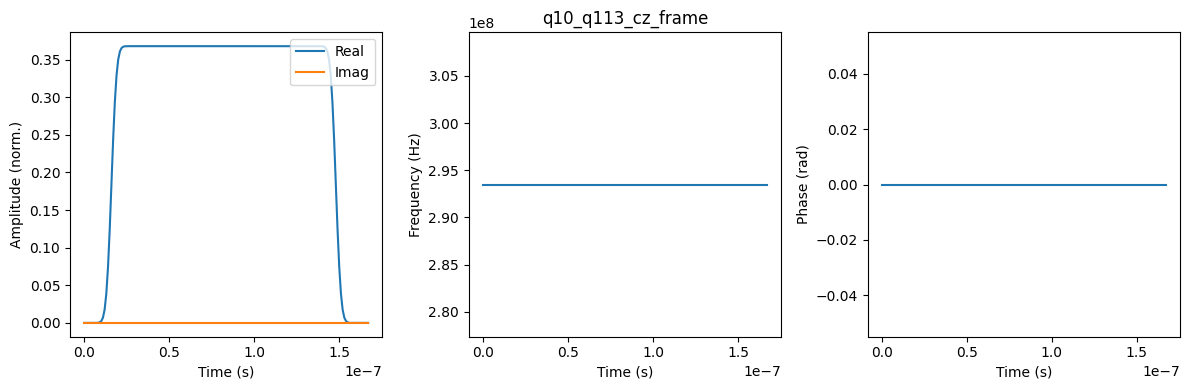

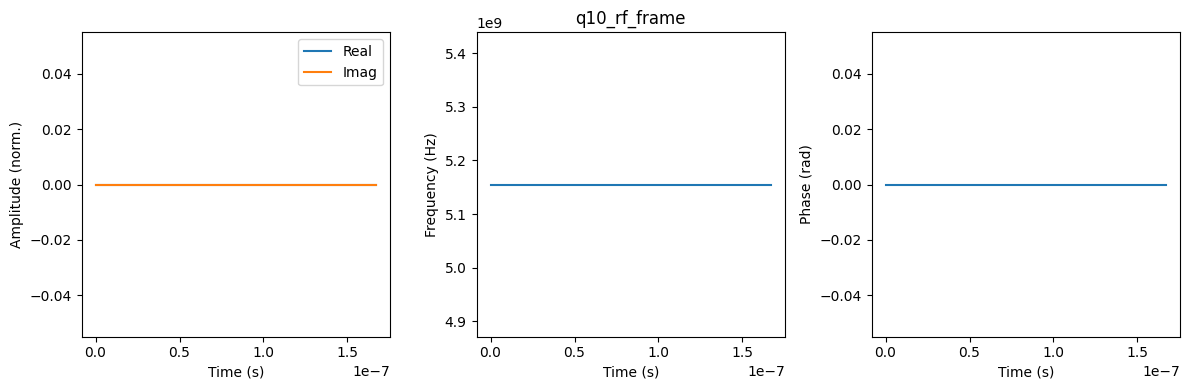

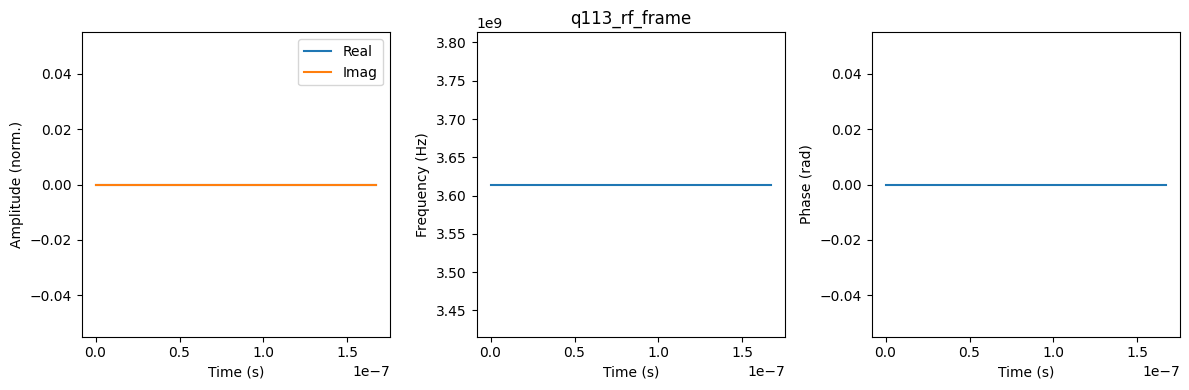

In [12]:
draw_multiple_frames(cz_pulse_sequence)

Finally, we can build our own implementation of the Bell circuit using a `pulse_gate` instruction that encapsulates the pulse sequence into a gate instructions. 

Pulse gates are strictly defined by the pulse sequence and the associated frames. The qubit or a list of qubits provided to `pulse_gate` are for representational purposes.

In [13]:
bell_pair_with_pulse = (
    Circuit()
    .rigetti_native_h(a)
    .rigetti_native_h(b)
    .pulse_gate([a, b], cz_pulse_sequence)
    .rigetti_native_h(b)
)
print(bell_pair_with_pulse)

T    : |   0    |   1    |   2    |    3    |4 |   5    |   6    |   7    |    8    |
                                                                                     
q10  : -Rz(3.14)-Rx(1.57)-Rz(1.57)-Rx(-1.57)-PG--------------------------------------
                                             |                                       
q113 : -Rz(3.14)-Rx(1.57)-Rz(1.57)-Rx(-1.57)-PG-Rz(3.14)-Rx(1.57)-Rz(1.57)-Rx(-1.57)-

T    : |   0    |   1    |   2    |    3    |4 |   5    |   6    |   7    |    8    |


Circuits with embedded pulse sequences can be executed normally.

As pulse sequences are inherently hardware dependent since the timings and strength of the waveforms are tuned to be optimal for the frame they are played on, you can only use pulse gates with the flag `disable_qubit_rewiring=True` that prevents any compiler to remap qubits. Amazon Braket SDK toggles automatically the flag when it detects that pulse sequences are embedded in a circuit.

Text(0, 0.5, 'Population')

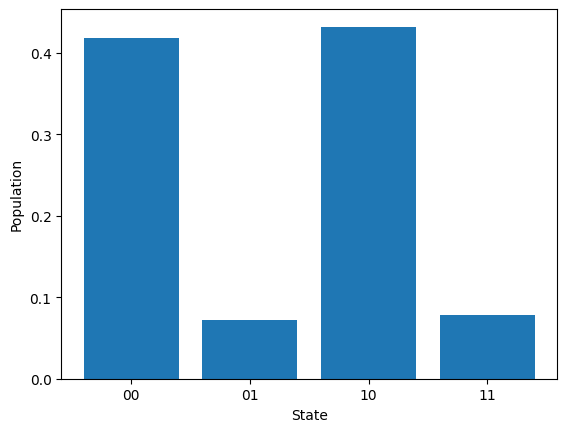

In [14]:
nb_shots = 500
task = device.run(bell_pair_with_pulse, shots=nb_shots, disable_qubit_rewiring=True)
counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

In [15]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 600, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.810 USD
